In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm
from scipy.stats import gaussian_kde

In [67]:
np.random.seed(42)
tf.random.set_seed(42)
DATA_PATH="/content/india_air_quality.csv"

In [68]:
df = pd.read_csv(DATA_PATH, encoding="latin")
df.columns = df.columns.str.strip().str.lower()
df.head()

/tmp/ipython-input-3610992397.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, encoding="latin")


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [69]:
no2_columns = []

for column_name in df.columns:
    if "no2" in column_name.lower():
        no2_columns.append(column_name)

print("NO2 columns found:", no2_columns)

selected_no2_column = no2_columns[0]

NO2 columns found: ['no2']


In [70]:
row_no2 = df[selected_no2_column]
x_vals = pd.to_numeric(row_no2, errors="coerce").dropna().astype(np.float32).values

In [71]:
x_vals = x_vals[np.isfinite(x_vals)]
x_vals = x_vals[x_vals >= 0]

print(
"x samples:", x_vals.shape[0],
"min:", float(x_vals.min()) if x_vals.size else None,
"max:", float(x_vals.max()) if x_vals.size else None
)

x samples: 419509 min: 0.0 max: 876.0


In [72]:
r=102317160
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r, "b_r =", b_r)

a_r = 0.5 b_r = 0.3


In [73]:
x_for_z = x_vals
z_vals = x_for_z + a_r * np.sin(b_r * x_for_z)
z_vals = z_vals.astype(np.float32)

In [74]:
z_mu = z_vals.mean()
z_sig = z_vals.std() + 1e-8

z_norm = (z_vals - z_mu) / z_sig

print("z normalized: mean~", float(z_norm.mean()), "std~", float(z_norm.std()))

z normalized: mean~ -3.142624649399295e-08 std~ 0.9999999403953552


In [75]:
BATCH_SIZE = 256

z_ds = (
tf.data.Dataset.from_tensor_slices(z_norm.reshape(-1, 1))
.shuffle(buffer_size=20000, seed=42)
.batch(BATCH_SIZE, drop_remainder=True)
)


In [76]:
LATENT_DIM = 32

def make_generator(latent_dim=LATENT_DIM):
    return tf.keras.Sequential(
    [
      tf.keras.layers.Input(shape=(latent_dim,)),
      tf.keras.layers.Dense(128),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Dense(128),
      tf.keras.layers.LeakyReLU(0.2),
      tf.keras.layers.Dense(1),
    ],
      name="Generator",
    )

def make_discriminator():
    return tf.keras.Sequential(
    [
      tf.keras.layers.Input(shape=(1,)),
      tf.keras.layers.Dense(64),
      tf.keras.layers.LeakyReLU(alpha=0.2),
      tf.keras.layers.Dense(64),
      tf.keras.layers.LeakyReLU(alpha=0.2),
      tf.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name="Discriminator",
    )

G = make_generator()
D = make_discriminator()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [77]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

g_opt = tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5)
d_opt = tf.keras.optimizers.Adam(learning_rate=5e-5, beta_1=0.5)

In [78]:
@tf.function
def train_step(real_batch):
    bs = tf.shape(real_batch)[0]
    noise = tf.random.normal(shape=(bs, LATENT_DIM))

    with tf.GradientTape() as d_tape, tf.GradientTape() as g_tape:
        fake_batch = G(noise, training=True)

        real_pred = D(real_batch, training=True)
        fake_pred = D(fake_batch, training=True)
        d_real_loss = bce(tf.ones_like(real_pred) * 0.9, real_pred)
        d_fake_loss = bce(tf.zeros_like(fake_pred), fake_pred)
        d_loss = d_real_loss + d_fake_loss
        g_loss = bce(tf.ones_like(fake_pred), fake_pred)

    d_grads = d_tape.gradient(d_loss, D.trainable_variables)
    g_grads = g_tape.gradient(g_loss, G.trainable_variables)

    d_opt.apply_gradients(zip(d_grads, D.trainable_variables))
    g_opt.apply_gradients(zip(g_grads, G.trainable_variables))

    return d_loss, g_loss

In [79]:
EPOCHS = 300

d_hist = []
g_hist = []

for epoch in range(1, EPOCHS + 1):
  d_sum = 0.0
  g_sum = 0.0
  n_batches = 0
  pbar = tqdm(z_ds, desc=f"Epoch {epoch}/{EPOCHS}", leave=False)

  for real_batch in pbar:
    d_loss, g_loss = train_step(real_batch)
    d_val = float(d_loss.numpy())
    g_val = float(g_loss.numpy())

    d_sum += d_val
    g_sum += g_val
    n_batches += 1

    pbar.set_postfix({"D_loss": f"{d_val:.4f}", "G_loss": f"{g_val:.4f}"})



  d_avg = d_sum / n_batches
  g_avg = g_sum / n_batches

  d_hist.append(d_avg)
  g_hist.append(g_avg)

  if epoch % 10 == 0:
    print(f"Epoch {epoch}: D_loss={d_avg:.4f}, G_loss={g_avg:.4f}")

Epoch 10: D_loss=1.3715, G_loss=0.8071


Epoch 20: D_loss=1.3740, G_loss=0.8033


Epoch 30: D_loss=1.3746, G_loss=0.8026


Epoch 40: D_loss=1.3749, G_loss=0.8020


Epoch 50: D_loss=1.3751, G_loss=0.8017


Epoch 60: D_loss=1.3751, G_loss=0.8014


Epoch 70: D_loss=1.3752, G_loss=0.8012


Epoch 80: D_loss=1.3750, G_loss=0.8016


Epoch 90: D_loss=1.3745, G_loss=0.8024


Epoch 100: D_loss=1.3743, G_loss=0.8028


Epoch 110: D_loss=1.3744, G_loss=0.8027


Epoch 120: D_loss=1.3747, G_loss=0.8018


Epoch 130: D_loss=1.3746, G_loss=0.8022


Epoch 140: D_loss=1.3746, G_loss=0.8025


Epoch 150: D_loss=1.3746, G_loss=0.8021


Epoch 160: D_loss=1.3747, G_loss=0.8023


Epoch 170: D_loss=1.3746, G_loss=0.8024


Epoch 180: D_loss=1.3748, G_loss=0.8022


Epoch 190: D_loss=1.3748, G_loss=0.8020


Epoch 200: D_loss=1.3749, G_loss=0.8020


Epoch 210: D_loss=1.3751, G_loss=0.8013


Epoch 220: D_loss=1.3750, G_loss=0.8014


Epoch 230: D_loss=1.3751, G_loss=0.8015


Epoch 240: D_loss=1.3751, G_loss=0.8011


Epoch 250: D_loss=1.3751, G_loss=0.8013


Epoch 260: D_loss=1.3750, G_loss=0.8016


Epoch 270: D_loss=1.3750, G_loss=0.8015


Epoch 280: D_loss=1.3751, G_loss=0.8016


Epoch 290: D_loss=1.3747, G_loss=0.8013


Epoch 300: D_loss=1.3750, G_loss=0.8015


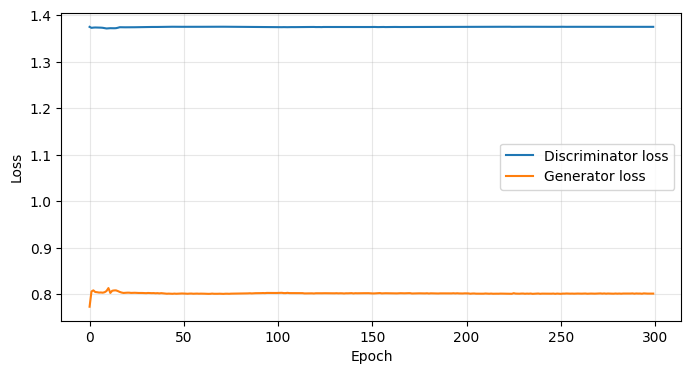

In [80]:
plt.figure(figsize=(8, 4))
plt.plot(d_hist, label="Discriminator loss")
plt.plot(g_hist, label="Generator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [81]:
N_GEN = 100000
noise = tf.random.normal(shape=(N_GEN, LATENT_DIM))
z_fake_norm = G(noise, training=False).numpy().reshape(-1)

z_fake = z_fake_norm * z_sig + z_mu
z_real = z_vals

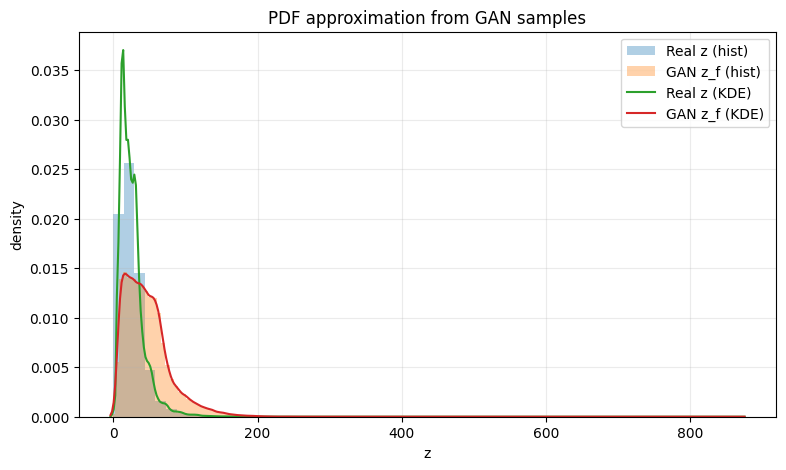

In [82]:
kde_real = gaussian_kde(z_real)
kde_fake = gaussian_kde(z_fake)

grid = np.linspace(min(z_real.min(), z_fake.min()), max(z_real.max(), z_fake.max()), 400)
p_real = kde_real(grid)
p_fake = kde_fake(grid)

plt.figure(figsize=(9, 5))
plt.hist(z_real, bins=60, density=True, alpha=0.35, label="Real z (hist)")
plt.hist(z_fake, bins=60, density=True, alpha=0.35, label="GAN z_f (hist)")
plt.plot(grid, p_real, label="Real z (KDE)")
plt.plot(grid, p_fake, label="GAN z_f (KDE)")
plt.xlabel("z")
plt.ylabel("density")
plt.title("PDF approximation from GAN samples")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()